# eROSITA Miscentering Distribution Analisis

## Introduzione

All'interno di questo breve elaborato si analizzeranno i dati ottenuti dalla survey di eROSITA con lo scopo principale di studiare la miscentering distribution degli ammassi di galassie. 
Con questo obiettivo è stato sviluppato un breve script in python che consente di elaborare i dati della survey basandosi su librerie atte all'analisi e alla rappresentazione dei dati.

Per facilitare la lettura il codice è stato suddiviso nelle seguenti macroaree:
1. **Analisi del catalogo**: estrazione, selezione e prima analisi dati
    - Lettura e selezione dati
    - Analisi della distribuzione delle distanze normalizzate
        - Distribuzione dei dati
        - Variazione distribuzione in funzione di massa e redsift
2. **Sviluppo dei modelli**: studio dei modelli descrittivi della distribuzione
    - Rappresentazione del modello *S15* al variare dei parametri
    - Rappresentazione del modello *Z19* al variare dei parametri
3. **Analisi Bayesiana**: verifica dell'accuratezza dei modelli per la rappresentazione dei dati
    - Modello *S15*
        - Fitting dei parametri con algoritmo emcee
        - Confronto dati - modello
        - Valutazione della riproducibilità dei dati mediante il modello
    - Modello *Z19*
        - Fitting dei parametri con algoritmo emcee
        - Confronto dati - modello
        - Valutazione della riproducibilità dei dati mediante il modello
    

### Librerie

Per la realizzazione e il corretto funzionamento di questo cript sono state utilizzate le seguenti librerie:

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
from scipy.optimize import minimize
from scipy.stats import chi2
import pygtc

## 1. Analisi del catalogo

### Lettura e selezione dati

Per il trattamento dei dati si è optato per l'utilizzo di dataframe pandas. 

In questo primo frammento si è generato un dataframe a partire dal file .csv contenente i dati della survey.

In [136]:
data = pd.read_csv('catalog_selected_columns_filtered_with_cluster_index.csv')
data.head()

,Unnamed: 0,NAME,RA_XFIT,DEC_XFIT,M500,R500,RA_OPT,DEC_OPT,RA_BCG,DEC_BCG,...,X_scaled_0,X_scaled_1,cluster,rho_m,rho_s,sigma0_m,sigma0_s,sigma1_m,sigma1_s,logM500
0,0,1eRASS J000005.2-383729,0.0214,-38.6250,36.07,971.0,0.0238,-38.626781,0.0238,-38.626781,...,-0.081623,0.778435,6,0.750582,0.027508,0.100183,0.007995,0.668959,0.040839,14.557146
1,1,1eRASS J000021.4-824954,0.0558,-82.8189,16.99,819.0,0.1768,-82.798203,0.1768,-82.798203,...,-1.230286,-0.425019,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.230193
2,2,1eRASS J000031.8-630131,0.1265,-63.0225,22.04,846.0,0.1254,-63.023071,0.1254,-63.023071,...,-0.439542,-0.046329,9,0.809312,0.024625,0.089089,0.006957,0.578245,0.038856,14.343212
3,3,1eRASS J000056.7-682010,0.2309,-68.3369,14.25,732.0,0.2301,-68.336777,0.1765,-68.372871,...,-0.456453,-0.657230,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.153815
4,4,1eRASS J000104.0-464435,0.2768,-46.7381,23.84,891.0,0.2840,-46.734661,0.2840,-46.734661,...,-0.809294,0.075927,22,0.779619,0.029719,0.058439,0.005577,0.514526,0.037597,14.377306


Successivamente sono stati estratti i dati di interesse riguardanti le distanze normalizzate (*BCG_offset_R500*), le masse (*logM500*) e il redshift (*BEST_Z*) degli ammassi

In [137]:
data = data.loc[:, ['BEST_Z', 'logM500', 'BCG_offset_R500']]
data.head(10)

,BEST_Z,logM500,BCG_offset_R500
0,0.31528,14.557146,0.044778
1,0.08909,14.230193,0.189587
2,0.24480,14.343212,0.012553
3,0.24147,14.153815,0.781392
4,0.17199,14.377306,0.071918
5,0.30403,14.217484,1.415935
6,0.32467,14.469822,0.291822
7,0.18463,13.889862,1.193630
8,0.23010,14.101403,0.037132
9,0.33544,14.155943,0.138859


### Analisi della distribuizone delle distanze normalizzate

#### Distribuzione dati

Ottenuti i dati si è generato un'istogramma delle distanze normalizzate con lo scopo di osservare la loro distribuzione.

array([0.03085186, 0.1211738 , 0.6983835 ])

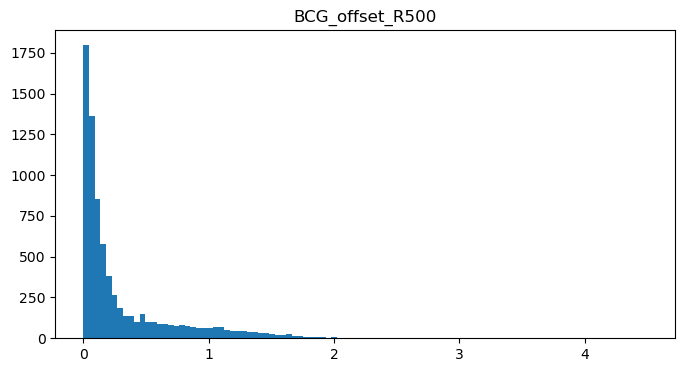

In [138]:
data.hist(column='BCG_offset_R500', bins=100, grid=False, figsize=(8,4))
np.percentile(data.BCG_offset_R500, [16, 50, 84])

si osserva una distribuzione con un rapido decadimento all'aumentare del valore della distanza normalizzata.

In particolare si osserva come la maggior parte degli ammassi presentino una distanza relativa tra il centro in banda X e il centro in banda ottica inferiore all'unità (considerando la normalizzazione). Più precisamente l'*84%* dei dati è contenuto nell'intervallo *[0 , 0.7)*

#### Analisi distribuzione in funzione di redshift e massa 

Per evidenziare la dipendenza della distribuzione da parametri quali massa e redshift si è optato per la realizzazione di due istogrammi bidimensionali. In questo modo è possibile osservare come al variare di uno dei due parametri (lungo un asse) si modifichi la distribuzione dei dati associati alle distanze normalizzate (descritta mediante l'istogramma lungo il secondo asse).

Per la realizzazione dell'istogramma bidimensionale è stato innanzitutto necessario suddividere i dati associati a ogni grandezza in analisi in diversi intervalli (bin).

In [139]:
data['logM500_binned'] = pd.cut(data['logM500'], bins=50)
data['BEST_Z_binned'] = pd.cut(data['BEST_Z'], bins=50)
data['BCG_offset_R500_binned'] = pd.cut(data['BCG_offset_R500'], bins=50)
data.head()

,BEST_Z,logM500,BCG_offset_R500,logM500_binned,BEST_Z_binned,BCG_offset_R500_binned
0,0.31528,14.557146,0.044778,"(14.518, 14.567]","(0.312, 0.334]","(-0.00367, 0.0908]"
1,0.08909,14.230193,0.189587,"(14.221, 14.271]","(0.0719, 0.0937]","(0.181, 0.271]"
2,0.24480,14.343212,0.012553,"(14.32, 14.37]","(0.225, 0.247]","(-0.00367, 0.0908]"
3,0.24147,14.153815,0.781392,"(14.123, 14.172]","(0.225, 0.247]","(0.72, 0.81]"
4,0.17199,14.377306,0.071918,"(14.37, 14.419]","(0.159, 0.181]","(-0.00367, 0.0908]"


Successivamente si è creata una griglia di valori sfruttando la separazione dei dati in intervalli. In particolare per la creazione della griglia si sono eseguiti i seguienti passaggi:
- raggruppamento dei dati in funzione delle possibili coppie di intervalli massa-distanza: verifica di quali valori rientrano all'interno della porzione di superficie definita dal prodotto degli intervalli in uno spazio 2D
- conteggio dei valori raggruppati 
- creazione di un dataframe in cui per ogni cella si ha un valore 

<!-- unstack apre il dataframe precedente e riempie ogni cella per cui si ha un conteggio non nullo con il rispettivo valore mentre quelle nulle sono automaticamente impostate a 0 --!>

In [140]:
hist_mass_data = data.groupby(['logM500_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()
hist_mass_data.head(10)

C:\Users\gioch\AppData\Local\Temp\ipykernel_14752\2047454251.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist_mass_data = data.groupby(['logM500_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()


BCG_offset_R500_binned,"(-0.00367, 0.0908]","(0.0908, 0.181]","(0.181, 0.271]","(0.271, 0.361]","(0.361, 0.451]","(0.451, 0.541]","(0.541, 0.63]","(0.63, 0.72]","(0.72, 0.81]","(0.81, 0.9]",...,"(3.599, 3.689]","(3.689, 3.779]","(3.779, 3.868]","(3.868, 3.958]","(3.958, 4.048]","(4.048, 4.138]","(4.138, 4.228]","(4.228, 4.318]","(4.318, 4.408]","(4.408, 4.498]"
logM500_binned,,,,,,,,,,,,,,,,,,,,,
"(12.738, 12.79]",0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
"(12.79, 12.839]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(12.839, 12.888]",0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(12.888, 12.938]",0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
"(12.938, 12.987]",0,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1
"(12.987, 13.037]",0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(13.037, 13.086]",1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"(13.086, 13.135]",3,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
"(13.135, 13.185]",1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [141]:
hist_z_data = data.groupby(['BEST_Z_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()
hist_z_data.head(10)

C:\Users\gioch\AppData\Local\Temp\ipykernel_14752\2266038405.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist_z_data = data.groupby(['BEST_Z_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()


BCG_offset_R500_binned,"(-0.00367, 0.0908]","(0.0908, 0.181]","(0.181, 0.271]","(0.271, 0.361]","(0.361, 0.451]","(0.451, 0.541]","(0.541, 0.63]","(0.63, 0.72]","(0.72, 0.81]","(0.81, 0.9]",...,"(3.599, 3.689]","(3.689, 3.779]","(3.779, 3.868]","(3.868, 3.958]","(3.958, 4.048]","(4.048, 4.138]","(4.138, 4.228]","(4.228, 4.318]","(4.318, 4.408]","(4.408, 4.498]"
BEST_Z_binned,,,,,,,,,,,,,,,,,,,,,
"(0.0489, 0.0719]",133,13,10,4,2,6,7,4,4,5,...,1,0,0,0,0,0,0,0,0,1
"(0.0719, 0.0937]",149,25,11,12,3,12,5,3,6,7,...,0,0,1,0,0,0,0,0,0,0
"(0.0937, 0.116]",185,29,10,10,6,9,1,2,4,6,...,1,0,0,0,0,0,0,0,0,0
"(0.116, 0.137]",154,41,19,7,5,8,7,4,8,7,...,0,0,0,0,0,0,0,0,0,0
"(0.137, 0.159]",204,54,32,12,11,7,8,6,9,5,...,0,0,0,0,0,0,0,0,0,0
"(0.159, 0.181]",193,63,16,9,7,6,7,10,5,5,...,0,0,0,0,0,0,0,0,0,0
"(0.181, 0.203]",201,55,26,11,10,6,9,8,9,5,...,0,0,0,0,0,0,0,0,0,0
"(0.203, 0.225]",215,83,26,20,14,7,7,8,4,10,...,0,0,0,0,0,0,0,0,0,0
"(0.225, 0.247]",189,72,21,14,6,9,13,8,6,6,...,0,0,0,0,0,0,0,0,0,0


Ottenuta la griglia di valori, si procede con la rappresentazione grafica. Per fare ciò è stata definita una funzione contenente il codice necessario per la realizzazione del grafico mediante l'utilizzo della libreria matplotlib. Tale funzione raccoglie in input gli indici di posizione della griglia come x e y mentre il valore nella cella corrispondente alla coppia di indici coincide con il numero di valori che rientrano nell'intervallo.

In [142]:
def plot_hist3D(x, y, z, title, labels):
    x, y = np.meshgrid(x, y) # creo una griglia di valori ripetendo x e y rispettivamente per y e x volte
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.bar3d(x, y, np.zeros_like(z), 0.05, 0.05, z, shade=True) # np.zeros_like(z) è il valore di z per la base del bar
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel('Counts')
    ax.set_title(title)
    plt.show()

Essendo la funzione così definita, è necessario un cambio di indicizzazione dei valori della griglia: i valori di x e y da inserire nel plot devono essere dei numeri e non degli intervalli, dunque si è optato per l'indicizzazione con il valore medio dell'intervallo arrotondato a 2 cifre dopo la virgola

In [143]:
hist_mass_data.index.map(lambda i: f'{i.mid:.2f}')
hist_mass_data.columns.map(lambda c: f'{c.mid:.2f}')

hist_z_data.index.map(lambda i: f'{i.mid:.2f}')
hist_z_data.columns.map(lambda c: f'{c.mid:.2f}')


CategoricalIndex(['0.04', '0.14', '0.23', '0.32', '0.41', '0.50', '0.59',
                  '0.68', '0.77', '0.85', '0.95', '1.04', '1.12', '1.21',
                  '1.31', '1.40', '1.48', '1.58', '1.67', '1.75', '1.84',
                  '1.94', '2.02', '2.12', '2.20', '2.29', '2.38', '2.47',
                  '2.56', '2.65', '2.74', '2.83', '2.92', '3.01', '3.10',
                  '3.19', '3.28', '3.37', '3.46', '3.55', '3.64', '3.73',
                  '3.82', '3.91', '4.00', '4.09', '4.18', '4.27', '4.36',
                  '4.45'],
                 categories=['0.04', '0.14', '0.23', '0.32', ..., '4.18', '4.27', '4.36', '4.45'], ordered=True, dtype='category', name='BCG_offset_R500_binned')

##### Istogramma dipendenza dalla massa

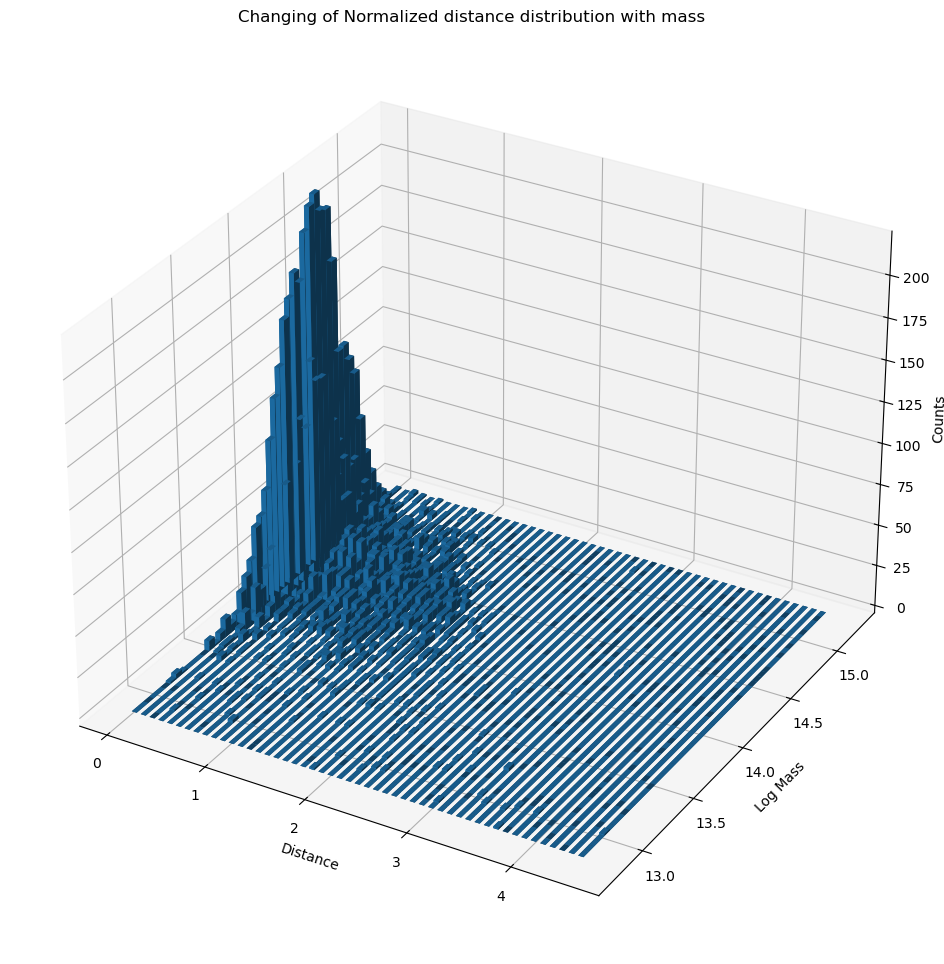

In [144]:
x = hist_mass_data.columns.map(lambda c: c.mid)
y = hist_mass_data.index.map(lambda i: i.mid)
z = hist_mass_data.values

plot_hist3D(x, y, z, 'Changing of Normalized distance distribution with mass', ['Distance', 'Log Mass'])

Dall'istogramma si deduce come la distribuzione delle distanze normalizzate vari seguendo un andamento approssimabile a una gaussiana: la distribuzione risulta essere circa piatta verso valori di massa attorno alle $10^{13} M_\odot$ , per poi crescere, culminare con un picco alle $10^{14} M_\odot$ dove la distribuzione è circa esponenziale e tornare a una distribuzione circa uniformemente nulla.

##### Istogramma dipendenza dal redshift

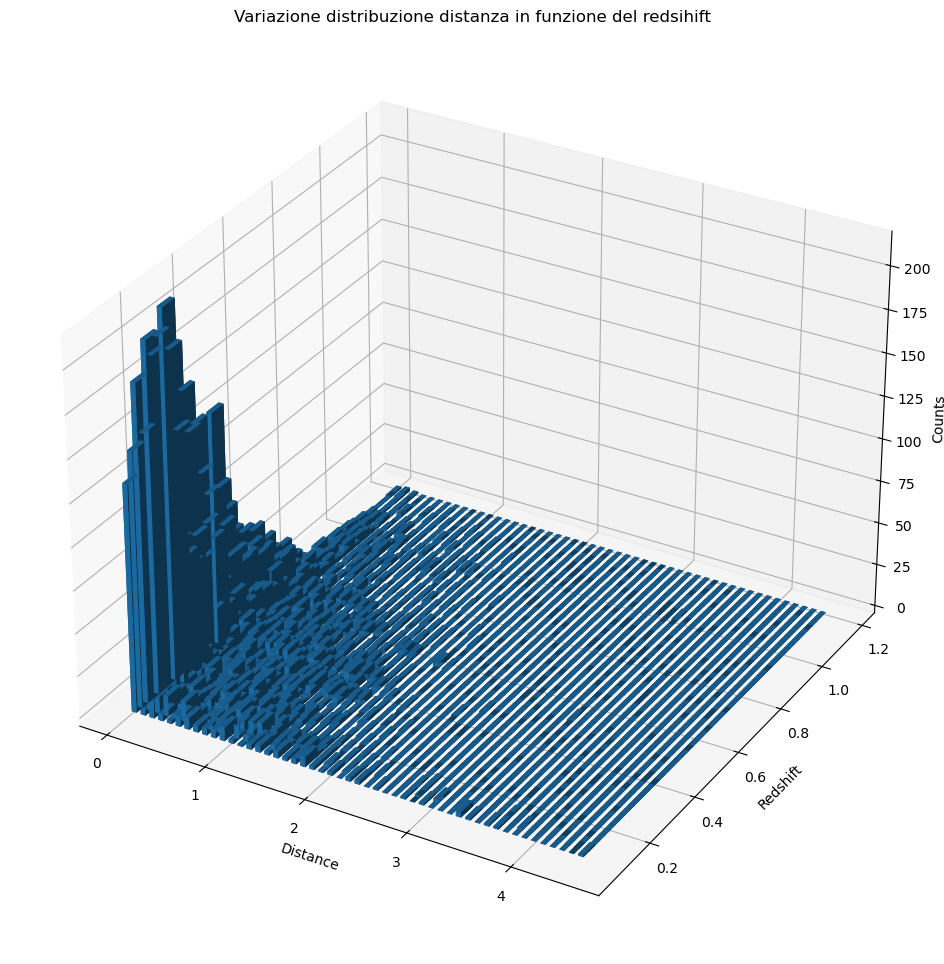

In [145]:
x = hist_z_data.columns.map(lambda c: c.mid)
y = hist_z_data.index.map(lambda i: i.mid)
z = hist_z_data.values

plot_hist3D(x, y, z, 'Variazione distribuzione distanza in funzione del redsihift', ['Distance', 'Redshift'])

In questo grafico invece, si osserva come la distribuzione risulti mantenere un andamento circa esponenziale con un picco introno a redshift 0.3 per poi diminuire all'aumentare del redshift. Ciò è probabilmente dovuto alla diminuzione dei dati a disposizione con l'aumentare della distanza dalla nostra galassia (ovvero all'aumentare del redshift).

## 2. Sviluppo dei modelli

In questa sezione si procede con lo studio dei modelli proposti per descrivere la distribuzione delle distanze normalizzate.

Si riporta il codice per l'implementazione delle funzioni rispettivamente associate ai modelli:
- **S15** (Saro et al. 2015)
- **Z19** (Zhang et al. 2019)

In [146]:
def S15(x, rho, sigma0, sigma1):
    return rho * x/sigma0**2 * np.exp(-0.5 * (x / sigma0)**2) + (1 - rho) * x/sigma1**2 * np.exp(-0.5 * (x / sigma1)**2)

def Z19(x, rho, sigma0, sigma1):
    return rho/sigma0 * np.exp(-(x / sigma0)) + (1 - rho) * x/sigma1**2 * np.exp(-(x / sigma1))


Queste due funzioni dipendono in modo parametrico da 3 quantità: $\rho$, $\sigma _0$ e $\sigma _1$ 

$\rho$ identifica la frazione di ammassi centrati corrrettamente e descritta dal parametro $\sigma _0$ mentre 1-$\rho$ coincide con la frazione di ammassi centrati erroneamente descritta dal parametro $\sigma _1$  

Al variare di questi tre parametri, varia la distribuzione descritta dai due modelli. All'interno delle due seguenti sezioni sono riportati codice e grafici per l'osservazione qualitativa di questa variazione.

### Rappresentazione Modello S15 al variare dei parametri

In [147]:
x = np.linspace(0, 1, 100)
rho = [0.1, 0.5, 0.9]
sigma0 = [0.1, 0.3, 0.7]
sigma1 = [0.1, 0.3, 0.7]

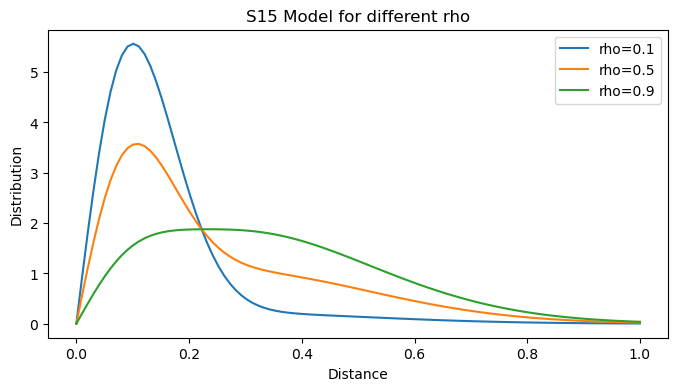

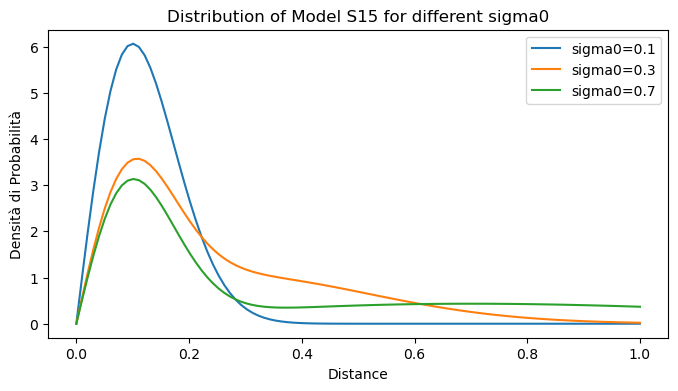

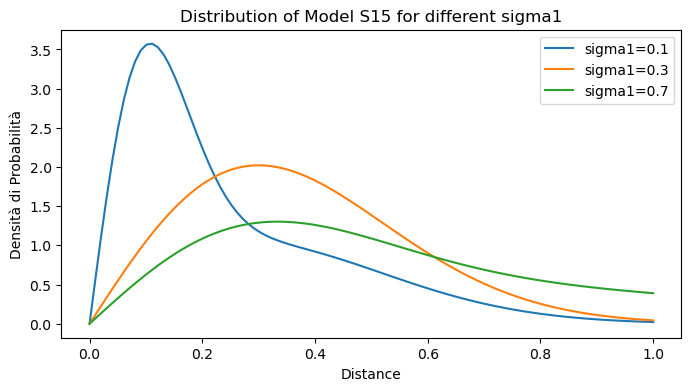

In [148]:
plt.figure(figsize=(8, 4))
for r in rho:
    plt.plot(x, S15(x, r, 0.3, 0.1), label=f'rho={r}')
plt.title('S15 Model for different rho')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()

plt.figure(figsize=(8, 4))
for s0 in sigma0:
    plt.plot(x, S15(x, 0.5, s0, 0.1), label=f'sigma0={s0}')
plt.title('Distribution of Model S15 for different sigma0')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()

plt.figure(figsize=(8, 4))
for s1 in sigma1:
    plt.plot(x, S15(x, 0.5, 0.3, s1), label=f'sigma1={s1}')
plt.title('Distribution of Model S15 for different sigma1')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()
plt.show()

Per il modello S15 si osserva che:
- all'aumentare del parametro $\rho$, la distribuzione varia il proprio valor medio in quanto il primo picco della distribuzione (assocato agli ammassi centrati erroneamente) diminuisce in favore del secondo picco (associato agli ammassi centrati correttamente)
- all'aumentare di $\sigma _0$, invece, aumenta la dispersione dei dati attorno al secondo picco
- all'aumentare di $\sigma _1$, infine, aumenta la dispersione associata al primo picco

### Rappresentazione del modello Z19 al variare dei parametri

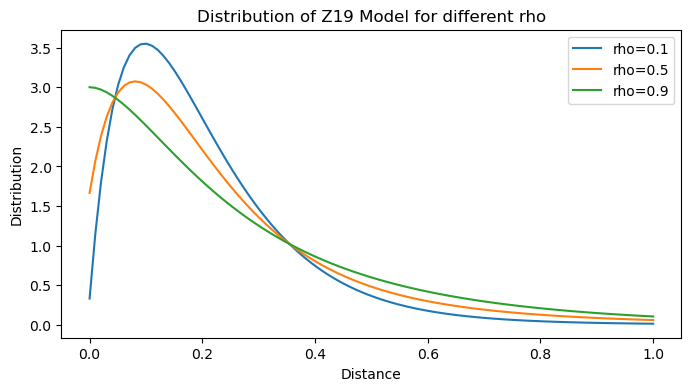

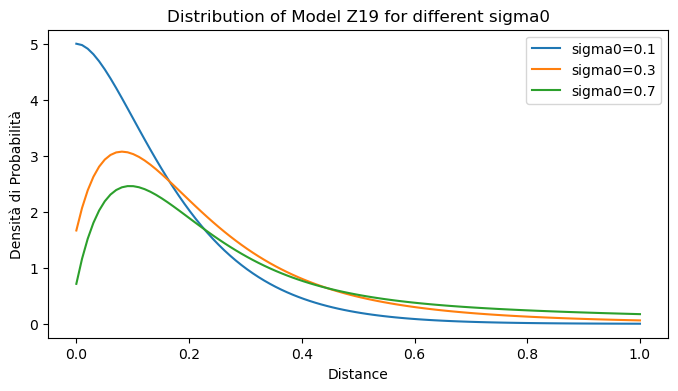

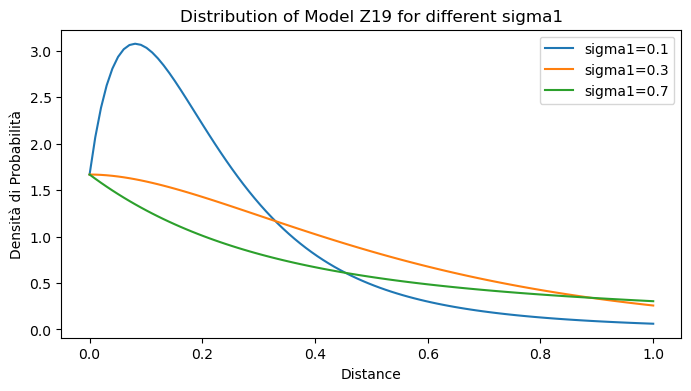

In [149]:
plt.figure(figsize=(8, 4))
for r in rho:
    plt.plot(x, Z19(x, r, 0.3, 0.1), label=f'rho={r}')
plt.title('Distribution of Z19 Model for different rho')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()

plt.figure(figsize=(8, 4))
for s0 in sigma0:
    plt.plot(x, Z19(x, 0.5, s0, 0.1), label=f'sigma0={s0}')
plt.title('Distribution of Model Z19 for different sigma0')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()

plt.figure(figsize=(8, 4))
for s1 in sigma1:
    plt.plot(x, Z19(x, 0.5, 0.3, s1), label=f'sigma1={s1}')
plt.title('Distribution of Model Z19 for different sigma1')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()
plt.show()

Per il modello Z15 si osserva che:
- all'aumentare del parametro $\rho$, aumenta la dispersione dei dati nonché il valore iniziale della funzione
- all'aumentare di $\sigma _0$, invece, aumenta la dispersione dei dati con un abbassamento del picco
- all'aumentare di $\sigma _1$, infine, aumenta la dispersione dei dati con un abbassamento e una deformazione del picco: tende ad assumere una derivata prima negativa in tutto il dominio

## 3. Analisi Bayesiana

In questa sezione si procede con l'analisi bayesiana dei dati e la valutazione dell'accuratezza dei modelli nella descrizione della distribuzione delle distanze normalizzate.

### Modello S15

#### Fitting dei parametri con algoritmo emcee

Per eseguire una corretta anlisi è necessario innanzitutto definire, secondo il *teorema di Bayes*, le funzioni di prior, likelihood e posterior. Per questa analisi si è optato per l'implementazione del logaritmo di queste funzioni per semplificare l'implementazione.

All'interno della prior sono stati inseriti dei vincoli sui parametri, ovvero:
- $\rho$ è stato assunto essere una quantità positiva e non maggiore di uno
- per $\sigma _0$ e $\sigma _1$ è stato imposto che fossero maggiori di 0

In [150]:
def log_prior(theta):
    rho, sigma0, sigma1 = theta
    if sigma0>0 and sigma1>0 and 0<=rho<=1:
        return 0.0
    return -np.inf

def log_likelihood(theta, x):
    rho, sigma0, sigma1 = theta
    model = S15(x, rho, sigma0, sigma1)
    return np.sum(np.log(model))

def log_posterior(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x)

Si procede con l'ottimizzazione dei parametri mediante la funzione *minimize* di scipy che ci consente di minimizzare la posterior negata (ovvero massimizzare la posterior) partendo dai dati e da alcuni valori iniziali dei parametri addizionati a del random noise.

In [151]:
np.random.seed(42)
f = lambda *args: -log_posterior(*args)

initial = np.array([0.5, 0.3, 0.3])*(1+ 0.1 * np.random.randn(3))

soln = minimize(f, initial, args=(data['BCG_offset_R500'],)) 
rho, sigma0, sigma1 = soln.x

c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Infine è stato implementato il processo di fit mediante algorimo emcee grazie alla funzione *EnsambleSampler* dell'omonimo pacchetto. Per il setup di questo algoritmo sono stati definiti 50 walkers per ogni parametro a cui è stata attribuita la posizione iniziale corrispondente al valore ottimizzato del rispettivo parametro con un random noise in aggiunta.

In [152]:
nwalkers = 50
ndim = 3      

pos = soln.x *(1+ 1e-4 * np.random.randn(nwalkers, ndim)) 

sampler = mc.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(data['BCG_offset_R500'],)
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [02:01<00:00, 16.46it/s]


Si riportano di seguito i grafici associati al procedimento di fitting:
- il primo grafico rappresenta la variazione del valore dei parametri a ogni iterazione dell'algoritmo
- il secondo mostra le distribuzioni marginali e le ellissi di correlazione dei parametri ottenute a partire dai valori assunti dai walkers durante le iterazioni dell'algoritmo

Per entrambi i grafici si è trascurato il periodo di burn-in assunto come 100 iterazioni

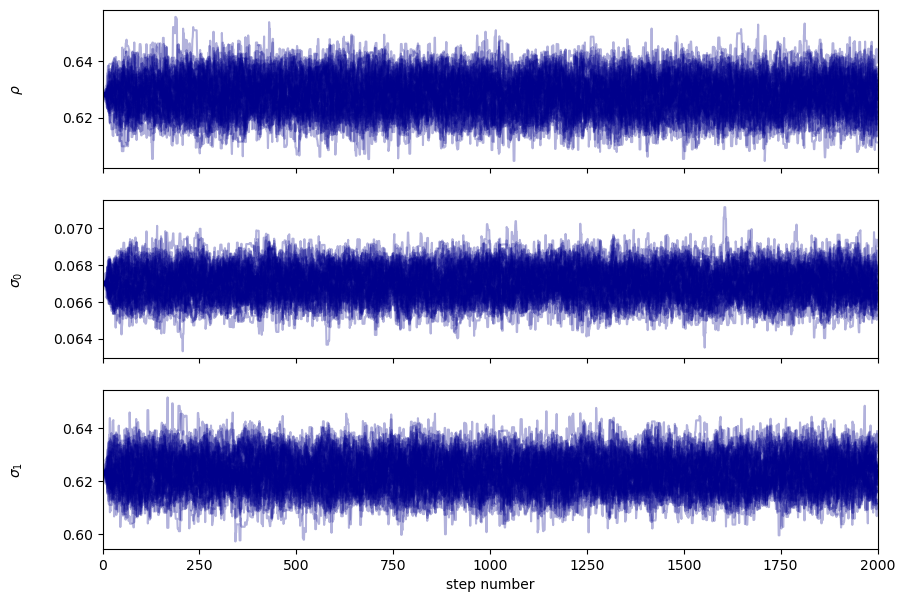

In [153]:
flat_samples = sampler.get_chain(discard=100, flat=True)   # estraggo i valori dei parametri nei vari passi del sampling eliminando i primi 100

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "darkblue", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

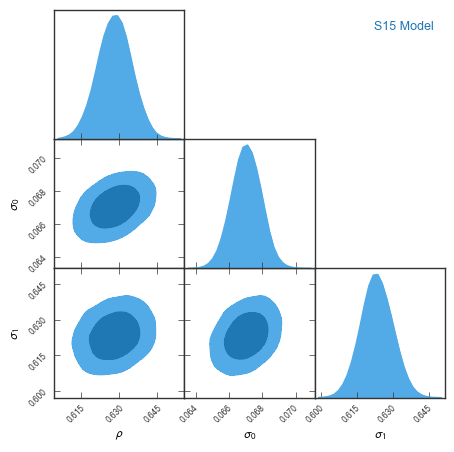

In [154]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"],
                    chainLabels=['S15 Model'],
                    figureSize='MNRAS_page')

#### Confronto dati - modello

Ottenuti i parametri si procede con una prima analisi grafica di quando il modello descrive correttamente i dati acquisiti. Con questo scopo si è rappresentata la funzione definita dal modello per valori dei parametri estratti dal fit precedente. I valori inseriti per questa analisi grafica sono quelli medi tra quelli assunti dai walkers durante il procedimento di fitting.

In [155]:
Srho = np.median(flat_samples[:, 0])
Ssigma0 = np.median(flat_samples[:, 1])
Ssigma1 = np.median(flat_samples[:, 2])

Srho, Ssigma0, Ssigma1

(0.6283684643945111, 0.06702895849715135, 0.6230403472854399)

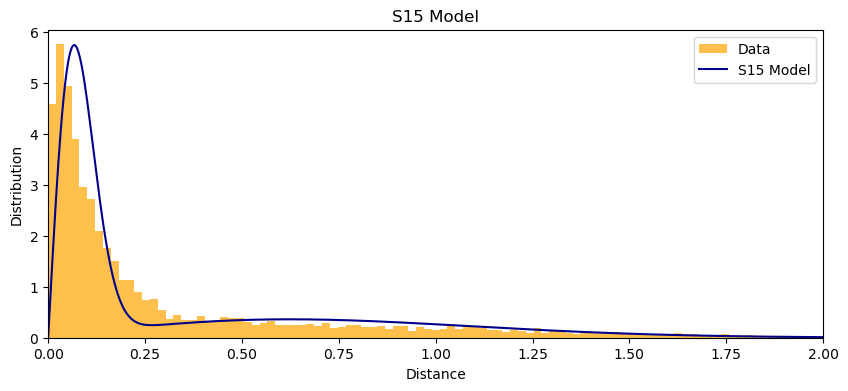

In [156]:
x = np.linspace(0, 2, 1000)
bins = np.linspace(0, 2, 100)

plt.figure(figsize=(10, 4))
plt.hist(data['BCG_offset_R500'], bins=bins, density=True, label='Data', color='orange', alpha=0.7)
plt.plot(x, S15(x, Srho, Ssigma0, Ssigma1), label='S15 Model', color='darkblue')
plt.xlim(0, 2)
plt.title('S15 Model')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.show()

Dal grafico si può osservare come il moedllo non sia del tutto coerente con i dati estratti dalla survey. La posizione del picco non coincide con quella evidenziata dalla distribuzione dei dati e sebbede l'andamento verso distanze normalizzate sopra l'unità sembra coerente, prima dell'unità il modello non risulta approssimare bene la distribuzione in diversi punti.

#### Valutazione della riproducibilità dei dati mediante il modello

Con l'obiettivo di valutare la riproducibilità dei dati a partire dal modello, si è generato un campione di dati casuale mediante l'algoritmo Metropolis-Hastings con una distribuzione dettata dal modello. Di seguito l'implementazione dell'algoritmo e della proposal function.

In [157]:
def metropolis_hastings(target_func, proposal_func, initial_value, n_samples):
    samples = [initial_value]
    current = initial_value
    rejected = []
    for _ in range(n_samples):
        candidate = proposal_func(current)
        accept_ratio = target_func(candidate) / target_func(current)
        if np.random.rand() < accept_ratio:
            current = candidate
        else: 
            rejected.append(candidate)
        samples.append(current)
    return samples[1:],rejected

In [158]:
def proposal_func(x):
    return np.abs(np.random.normal(x,2))


Per tenere conto dell'errore associato ai parametri e propagarlo al modello, questi vengono generati casualmente approssimando la loro distribuzione a una normale centrata sul valor medio e con deviazione standard estratta dalla distribuzione ottenuta in seguito al processo di fit.

In [159]:
sig_r = np.std(flat_samples[:, 0])
sig_s0 = np.std(flat_samples[:, 1])
sig_s1 = np.std(flat_samples[:, 2])

target_func = lambda x: S15(x, np.random.normal(Srho, sig_r), np.random.normal(Ssigma0, sig_s0), np.random.normal(Ssigma1, sig_s1))

samples, rejected = metropolis_hastings(target_func, proposal_func, 1, 100000)

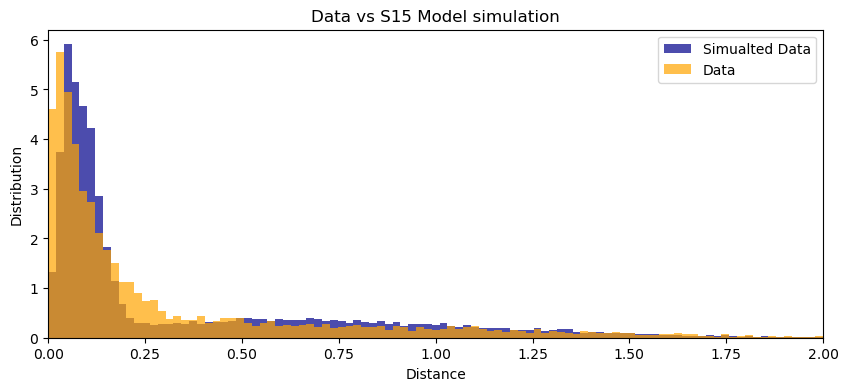

In [160]:
plt.figure(figsize=(10, 4))
plt.hist(samples, bins=bins, density=True, alpha=0.7, color='darkblue', label='Simualted Data')
plt.hist(data['BCG_offset_R500'], bins=bins, density=True, alpha=0.7, color='orange', label='Data')
plt.title('Data vs S15 Model simulation')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.xlim(0, 2)
plt.show()


La distribuzione del campione casuale generato secondo il modello S15 presenta le stesse incongrueze con i dati evidenziate per la funzione di distribuzione.

Ciò suggerisce che il modello S15 non sia il modello più adatto alla descrizione della distribuzione delle distanze normalizzate.

### Modello Z19

La stessa analisi è stata applicata al secondo modello sotto esame.

#### Fitting dei parametri con algoritmo emcee

In [161]:
def log_likelihood(theta, x):
    rho, sigma0, sigma1 = theta
    model = Z19(x, rho, sigma0, sigma1)
    return np.sum(np.log(model))

In [162]:
np.random.seed(42)      
f = lambda *args: -log_posterior(*args)

initial = np.array([0.5, 0.3, 0.3])*(1+ 0.1 * np.random.randn(3)) 
soln = minimize(f, initial, args=(data['BCG_offset_R500'],))  
rho, sigma0, sigma1 = soln.x   

c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [163]:
pos = soln.x *(1+ 1e-4 * np.random.randn(nwalkers, ndim))    

sampler = mc.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(data['BCG_offset_R500'],)     
)
sampler.run_mcmc(pos, 2000, progress=True);    

100%|██████████| 2000/2000 [01:29<00:00, 22.39it/s]


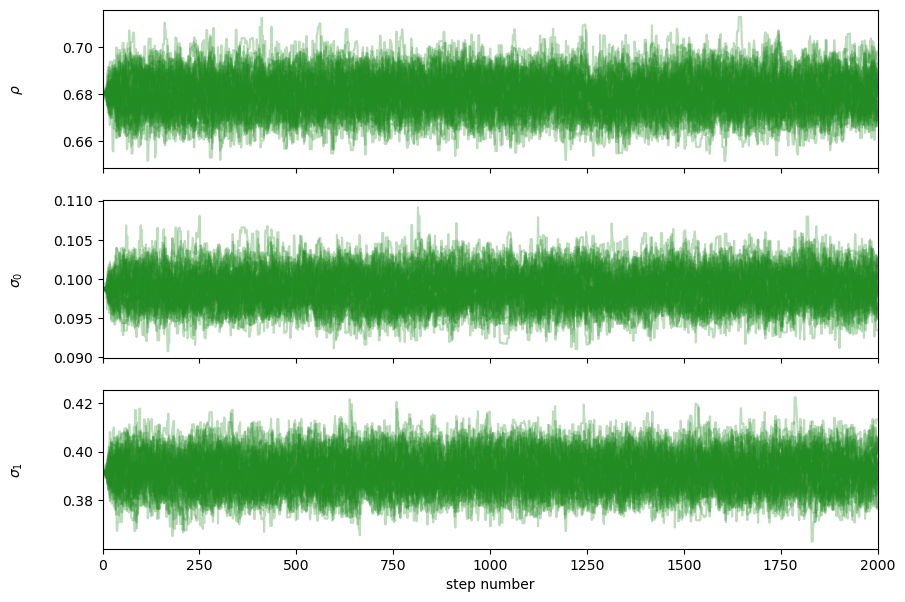

In [164]:
flat_samples = sampler.get_chain(discard=100, flat=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "forestgreen", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

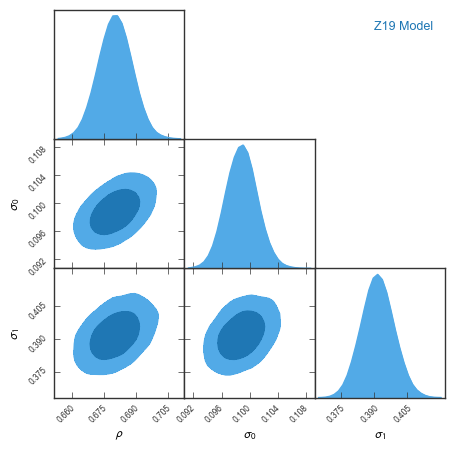

In [165]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"],
                    chainLabels=['Z19 Model'],
                    figureSize='MNRAS_page')

#### Confronto dati-modello

In [166]:
Zrho = np.median(flat_samples[:, 0])
Zsigma0 = np.median(flat_samples[:, 1])
Zsigma1 = np.median(flat_samples[:, 2])

Zrho, Zsigma0, Zsigma1

(0.6801957433727301, 0.09881392627269925, 0.3916523835548002)

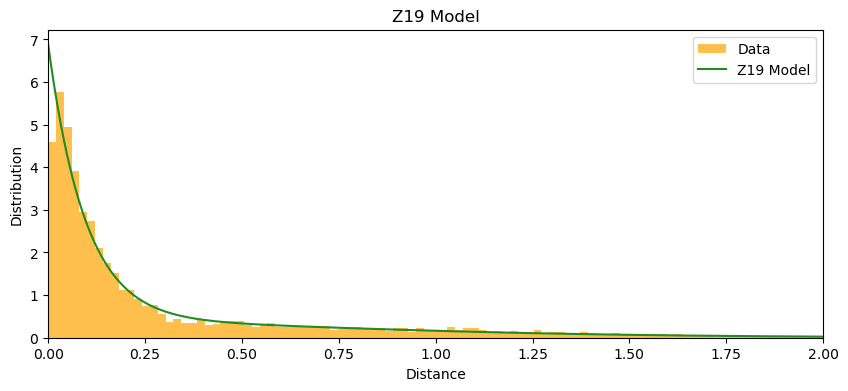

In [167]:
x = np.linspace(0, 2, 1000)

plt.figure(figsize=(10, 4))
plt.hist(data['BCG_offset_R500'], bins=bins, density=True, label='Data', color='orange', alpha=0.7)
plt.plot(x, Z19(x, Zrho, Zsigma0, Zsigma1), label='Z19 Model', color='forestgreen')
plt.xlim(0, 2)
plt.title('Z19 Model')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.show()

Il modello sembra riprodurre i dati in modo efficace eccetto per i valori vicini allo zero, dove il modello prevedrebbe una crescita esponenziale. Infatti come si può notare dal grafico, tale andamento non è coerente con i dati della survey.

#### Valutazione della riproducibilità dei dati mediante il modello

In [168]:
Zsig_r = np.std(flat_samples[:, 0])
Zsig_s0 = np.std(flat_samples[:, 1])
Zsig_s1 = np.std(flat_samples[:, 2])

In [169]:
target_func = lambda x: Z19(x, np.random.normal(Zrho, Zsig_r), np.random.normal(Zsigma0, Zsig_s0), np.random.normal(Zsigma1, Zsig_s1))

samples, rejected = metropolis_hastings(target_func, proposal_func, 1, 100000)

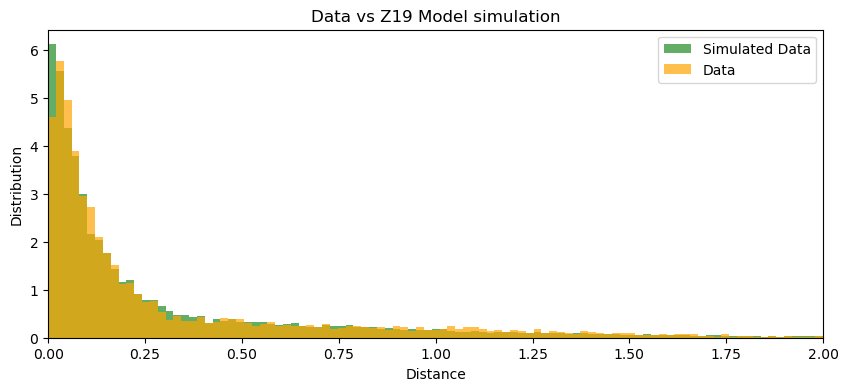

In [170]:
plt.figure(figsize=(10, 4))
plt.hist(samples, bins=bins, density=True, alpha=0.7, color='forestgreen', label='Simulated Data')
plt.title('Data vs Z19 Model simulation')
plt.hist(data['BCG_offset_R500'], bins=bins, density=True, alpha=0.7, color='orange', label='Data')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.xlim(0, 2)
plt.show()

L'istogramma ottenuto mediante il campione generato casualmente secondo la distribuzione dettata dal modello Z19 conferma le affermazioni precdenti: il modello, nonostante l'incertezza sui parametri, sembra riprodurre abbastanza fedelmente i dati. Tuttavia, come già evidenziato in precedenza, l'andamento previsto dal modello non è coerente con i dati in prossimità dello 0.

## Conclusioni

A fronte dell'analisi eseguita, si evince come i due modelli considerati non siano del tutto adeguati per riprodurre fedelmente la distribuzione delle distanze normalizzate. 

Il modello S15 presenta diverse incongruenze che non sono compensabili con la variazione dei parametri in analisi. Nonostante il fit abbia fornito dei parametri mediante i quali è possibibile ricreare parzialmente il campione di dati, comunque il modello manca di un termine o parametro in grado di eliminare il vincolo della funzione in 0. Infatti si osserva come, indipendentemente dal valore dei parametri, la funzione passa sempre per 0 in 0. Tale vincolo risulta eccessivo in quanto presuppone di non avere a disposizione dati per cui il miscentering risulta nullo ma soprattutto che gli ammassi noti con basso miscentering (molto vicino allo zero) risultano pochi rispetto a quelli con un valore maggiore. 

Il modello Z19, invece, rappresenta i dati in modo più efficace, consentendo anche di generare campioni casuali simili a quelli ottenuti mediante la survey. Tuttavia anche questo modello sembra presentare delle incongruenze con i dati in quanto il valore di ammassi con miscentering nullo risulta minore dai dati rispetto al valore atteso secondo il modello. Il fit dei parametri potrebbe avere una certa influenza su tale caratteristica della distribuzione prevista in quanto, come osservato nella sezione 2.2, variando i parametri è possibile riprodurre un massimo assoluto nella distribuzione e generare così un intervallo in cui la funzione presenta una derivata positiva prima del valore massimo, in modo tale da riprodurre più fedelmente i dati.

Infine, per quantificare meglio la riproducibilità dei dati da parte dei due modelli, sarebbe possibile eseguire un test d'ipotesi sui campioni generati ed eseguirne uno studio in funzione dei parametri di fit, in modo tale da confermare la qualità del fit e correggerlo nell'eventualità in cui sia posibile farlo.